In [255]:
import os
import sys
import numpy as np
import pandas as pd
from scipy import stats

# How to use
1. If you want to have a wrapper function to compute EER, please go to Section 1.
2. If you want to know more details on EER computation, please all the sections.

# Section 1 Wrapper to Compute Countermeasure EER


In some of the projects in this repository, the code only produces a score file on a test set. It does not compute the EER.

Computing EER is straightforward, but it requires engineering efforts to define the format of input data and so on.

So, I prefer separating the code for scoring a test set and the code for computing EER.

Here is the wrapper function to compute EER and examples of usage. 

More explanation on EER is in the next section.

## Core functions

In [256]:
# Core functions to compute FAR, FRR, and EER
#
# From ASVspoof official package https://www.asvspoof.org/resources/tDCF_python_v2.zip
def compute_det_curve(target_scores, nontarget_scores):
    """ frr, far, thresholds = compute_det_curve(target_scores, nontarget_scores)
    
    input
    -----
      target_scores:    np.array, score of target (or positive, bonafide) trials
      nontarget_scores: np.array, score of non-target (or negative, spoofed) trials
      
    output
    ------
      frr:         np.array,  false rejection rates measured at multiple thresholds
      far:         np.array,  false acceptance rates measured at multiple thresholds
      thresholds:  np.array,  thresholds used to compute frr and far

    frr, far, thresholds have same shape = len(target_scores) + len(nontarget_scores) + 1
    """
    n_scores = target_scores.size + nontarget_scores.size
    all_scores = np.concatenate((target_scores, nontarget_scores))
    labels = np.concatenate((np.ones(target_scores.size),
                             np.zeros(nontarget_scores.size)))

    # Sort labels based on scores                                                         
    indices = np.argsort(all_scores, kind='mergesort')
    labels = labels[indices]

    # Compute false rejection and false acceptance rates                                  
    tar_trial_sums = np.cumsum(labels)
    nontarget_trial_sums = (nontarget_scores.size -
                            (np.arange(1, n_scores + 1) - tar_trial_sums))

    frr = np.concatenate((np.atleast_1d(0), tar_trial_sums/target_scores.size))
    # false rejection rates                                                               
    far = np.concatenate((np.atleast_1d(1),
                          nontarget_trial_sums / nontarget_scores.size))
    # false acceptance rates                                                              
    thresholds = np.concatenate((np.atleast_1d(all_scores[indices[0]] - 0.001),
                                 all_scores[indices]))
    # Thresholds are the sorted scores                                                    
    return frr, far, thresholds


def compute_eer(target_scores, nontarget_scores):
    """ eer, eer_threshold = compute_det_curve(target_scores, nontarget_scores)
    
    input
    -----
      target_scores:    np.array, score of target (or positive, bonafide) trials
      nontarget_scores: np.array, score of non-target (or negative, spoofed) trials
      
    output
    ------
      eer:              scalar,  value of EER
      eer_threshold:    scalar,  value of threshold corresponding to EER
    """
    frr, far, thresholds = compute_det_curve(target_scores, nontarget_scores)
    abs_diffs = np.abs(frr - far)
    min_index = np.argmin(abs_diffs)
    eer = np.mean((frr[min_index], far[min_index]))
    return eer, thresholds[min_index]

## Interface

Let's suppose the score file and protocol are both in text format. 

The score should have (at least) two columns 
```
TRIAL_NAME CM_SCORE
LA_E_2834763 -12.0
LA_E_8877452 -12.4
LA_E_6828287 -15.9
LA_E_6977360 -12.3
LA_E_5932896 -2.0
LA_E_5849185 16.0
...
```

The protocol should have multiple columns including trial name and label. In the case of ASVspoof 2019 LA:
```
SPEAKER TRIAL_NAME DUMMY SPOOFING_ATTACK LABEL
LA_0039 LA_E_2834763 - A11 spoof
LA_0014 LA_E_8877452 - A14 spoof
LA_0040 LA_E_6828287 - A16 spoof
LA_0022 LA_E_6977360 - A09 spoof
LA_0031 LA_E_5932896 - A13 spoof
LA_0030 LA_E_5849185 - - bonafide
```

With the above formats in mind, we can use Pandas to write an Interface.

In [257]:
def compute_eer_API(score_file, protocol_file):
    """eer = compute_eer_API(score_file, protocol_file)
    
    input
    -----
      score_file:     string, path to the socre file
      protocol_file:  string, path to the protocol file
    
    output
    ------
      eer:  scalar, eer value
      
    The way to load text files using read_csv depends on the text format.
    Please change the read_csv if necessary
    """
    # load score
    score_pd = pd.read_csv(score_file, sep = ' ', names = ['trial', 'score'], index_col = 'trial', skipinitialspace=True)
    # load protocol
    protocol_pd = pd.read_csv(protocol_file, sep = ' ', names = ['speaker', 'trial', '-', 'attack', 'label'], index_col = 'trial')
    # joint together
    merged_pd = score_pd.join(protocol_pd)
    
    #
    bonafide_scores = merged_pd.query('label == "bonafide"')['score'].to_numpy()
    spoof_scores = merged_pd.query('label == "spoof"')['score'].to_numpy()
    
    eer, _ = compute_eer(bonafide_scores, spoof_scores)
    return eer

## Example usage

We will download some files from ASVspoof 2019 LA.

In [258]:
# Load prepared protocol and score files
!wget --quiet --show-progress -O asvspoof2019_la_package.zip https://www.dropbox.com/sh/v478xufxikv8bz8/AADZ-3NKnBh-H_pDO1z8DAcOa

# unzip
!unzip -q -o asvspoof2019_la_package.zip -x / -d ./

asvspoof2019_la_pac 100%[===================>]   3.92M  13.7MB/s    in 0.3s    


In [259]:
!head -n 3 ASVspoof2019.LA.cm.eval.score.txt

LA_E_1000147  -10.676333
LA_E_1000273  -12.736889
LA_E_1000791  -27.387339


In [260]:
!head -n 3 ASVspoof2019.LA.cm.eval.trl.txt

LA_0039 LA_E_2834763 - A11 spoof
LA_0014 LA_E_8877452 - A14 spoof
LA_0040 LA_E_6828287 - A16 spoof


In [261]:
eer = compute_eer_API('ASVspoof2019.LA.cm.eval.score.txt', './ASVspoof2019.LA.cm.eval.trl.txt')
print("EER (%): {:.4f}".format(eer * 100))

EER (%): 3.1950


# Section 2 EER step-by-step


## FAR and FRR

The equal error rate (EER) is widely used in biometrics and other binary classification or verification tasks. Hence, many papers and books describe it (see [1] for example).

It is based on idea of True / False - positive / negative (https://en.wikipedia.org/wiki/False_positives_and_false_negatives). 

Here, we mainly care about the errors, i.e., false positive (false acceptance) and false negative (false rejection)

* false acceptance: a spoofed trial (negative) is misclassed as being bonafide (positive)
* false rejection: a bona fide trial (positive) is misclassed as being spoof (negative)



Text(1.0099009900990104, 0, 'False acceptance')

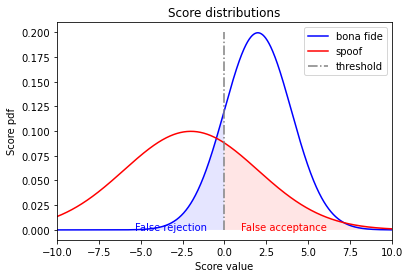

In [262]:
from scipy.stats import norm
x = np.linspace(-100, 100, 10000)
score_bona_pdf = norm.pdf(x, loc=2.0, scale=2)
score_spoof_pdf = norm.pdf(x, loc=-2.0, scale=4)
threshold = 0.0

import matplotlib.pyplot as plt
fig = plt.figure()
axis = fig.add_subplot(111)
axis.plot(x, score_bona_pdf, label = 'bona fide', color = 'b')
axis.plot(x, score_spoof_pdf, label = 'spoof', color = 'r')
axis.set_title('Score distributions')
axis.set_xlabel('Score value')
axis.set_ylabel('Score pdf')
axis.set_xlim(-10, 10)
axis.plot([threshold, threshold], [0, 0.2], label = 'threshold', color = 'grey', linestyle='-.')
axis.legend()


spoof_region = x<threshold
bona_region = x>=threshold
axis.fill_between(x[spoof_region], np.zeros_like(x[spoof_region]), score_bona_pdf[spoof_region], facecolor='b', alpha=0.1)
axis.fill_between(x[bona_region], np.zeros_like(x[bona_region]), score_spoof_pdf[bona_region], facecolor='r', alpha=0.1)
axis.text(np.percentile(x[spoof_region], 99), 0, "False rejection", color='b', ha='right')
axis.text(np.percentile(x[bona_region], 1), 0, "False acceptance", color='r', ha='left')

If we consider the **rate**, we need to compute:
* False rejection rate (FRR): the ratio between the size of the blue-shaded area and the size under the blue curve
* False acceptation rate (FAR): the ratio between the size of the blue-shaded area and the size under the red curve

The whole area under the blue (or red) curve is 1.0 since the curve is a p.d.f. 

Put another way, given the p.d.f of score distribution $p_{\text{spoof}}(s)$, $p_{\text{bona}}(s)$, and a threshold $\tau_{\text{cm}}$, we theoretically compute the FAR and FRR using integration (see Eq.(4) in [4])

$\begin{align}
P_{\text{FAR}}(\tau_{\text{cm}}) &= \int_{\tau_{\text{cm}}}^{+\infty} P_{\text{spoof}}(s) ds \\
P_{\text{FRR}}(\tau_{\text{cm}}) &= \int_{-\infty}^{\tau_{\text{cm}}} P_{\text{bona}}(s) ds \\
\end{align}$



However, we usually can only approximate the integration.

The basic idea is integration as summation: $\sum_i P(s_i) \Delta s$ (https://en.wikipedia.org/wiki/Riemann_sum)

We can compute FRR and FAR:

Text(1.0099009900990104, 0, 'FAR = 30.85%')

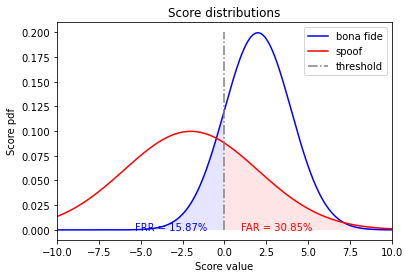

In [263]:
# In practice, we only have discrete bins in the p.d.f 
# compute the bin size \Delta s
binsize = np.mean(np.diff(x))

spoof_region = x<threshold
bona_region = x>=threshold

area_under_r_curve = np.sum(score_spoof_pdf) * binsize
area_under_b_curve = np.sum(score_bona_pdf) * binsize

fr = np.sum(score_bona_pdf[spoof_region]) * binsize
fa = np.sum(score_spoof_pdf[bona_region]) * binsize

frr = fr / area_under_b_curve
far = fa / area_under_r_curve


# replot the figure
import matplotlib.pyplot as plt
fig = plt.figure()
axis = fig.add_subplot(111)
axis.plot(x, score_bona_pdf, label = 'bona fide', color = 'b')
axis.plot(x, score_spoof_pdf, label = 'spoof', color = 'r')
axis.set_title('Score distributions')
axis.set_xlabel('Score value')
axis.set_ylabel('Score pdf')
axis.set_xlim(-10, 10)
axis.plot([threshold, threshold], [0, 0.2], label = 'threshold', color = 'grey', linestyle='-.')
axis.legend()
axis.fill_between(x[spoof_region], np.zeros_like(x[spoof_region]), score_bona_pdf[spoof_region], facecolor='b', alpha=0.1)
axis.fill_between(x[bona_region], np.zeros_like(x[bona_region]), score_spoof_pdf[bona_region], facecolor='r', alpha=0.1)
axis.text(np.percentile(x[spoof_region], 99), 0, "FRR = {:.2f}%".format(frr * 100), color='b', ha='right')
axis.text(np.percentile(x[bona_region], 1), 0, "FAR = {:.2f}%".format(far * 100), color='r', ha='left')

## Impact of threshold

FRR and FAR are affected by the threshold. 

Let's try to change the threshold.

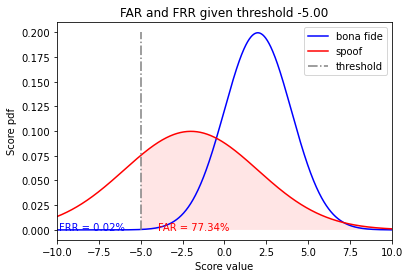

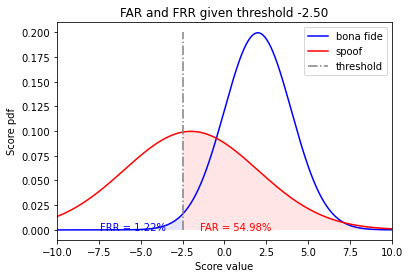

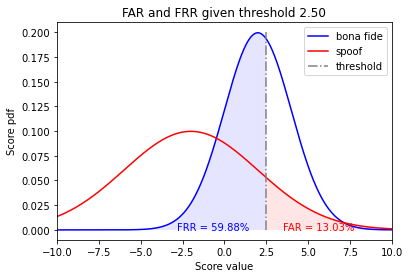

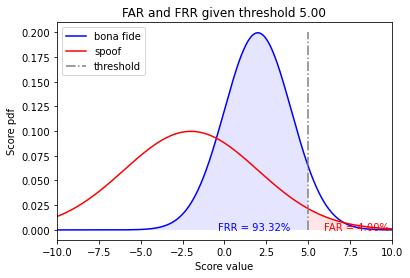

In [264]:
thresholds = [-5.0, -2.5, 2.5, 5.0]

for threshold in thresholds:
    binsize = np.mean(np.diff(x))

    spoof_region = x<threshold
    bona_region = x>=threshold
    area_under_r_curve = np.sum(score_spoof_pdf) * binsize
    area_under_b_curve = np.sum(score_bona_pdf) * binsize
    fr = np.sum(score_bona_pdf[spoof_region]) * binsize
    fa = np.sum(score_spoof_pdf[bona_region]) * binsize
    frr = fr / area_under_b_curve
    far = fa / area_under_r_curve

    fig = plt.figure()
    axis = fig.add_subplot(111)
    axis.plot(x, score_bona_pdf, label = 'bona fide', color = 'b')
    axis.plot(x, score_spoof_pdf, label = 'spoof', color = 'r')
    axis.set_title('FAR and FRR given threshold {:.2f}'.format(threshold))
    axis.set_xlabel('Score value')
    axis.set_ylabel('Score pdf')
    axis.set_xlim(-10, 10)
    axis.plot([threshold, threshold], [0, 0.2], label = 'threshold', color = 'grey', linestyle='-.')
    axis.legend()
    axis.fill_between(x[spoof_region], np.zeros_like(x[spoof_region]), score_bona_pdf[spoof_region], facecolor='b', alpha=0.1)
    axis.fill_between(x[bona_region], np.zeros_like(x[bona_region]), score_spoof_pdf[bona_region], facecolor='r', alpha=0.1)
    axis.text(np.percentile(x[spoof_region], 99), 0, "FRR = {:.2f}%".format(frr * 100), color='b', ha='right')
    axis.text(np.percentile(x[bona_region], 1), 0, "FAR = {:.2f}%".format(far * 100), color='r', ha='left')

## DET Curve

If we gradually move the threshold from left to right, we will get a pair of {FAR, FRR} for each threshold value we take. 


In [265]:
# set the threshold range from -10 to 10
# it can be larger of course

thresholds = np.arange(-10, 10, 0.01)

far_array = np.zeros_like(thresholds)
frr_array = np.zeros_like(thresholds)

for idx, threshold in enumerate(thresholds):
    
    # same method as before
    # area under the whole distribution (which should be 1.0)
    area_under_r_curve = np.sum(score_spoof_pdf) * binsize
    area_under_b_curve = np.sum(score_bona_pdf) * binsize

    # get the region for classifying spoof and bona fide 
    spoof_region = x<threshold
    bona_region = x>=threshold
    # get the size of shaded region
    fr = np.sum(score_bona_pdf[spoof_region]) * binsize
    fa = np.sum(score_spoof_pdf[bona_region]) * binsize
    # rate
    frr = fr / area_under_b_curve
    far = fa / area_under_r_curve
    
    frr_array[idx] = frr
    far_array[idx] = far



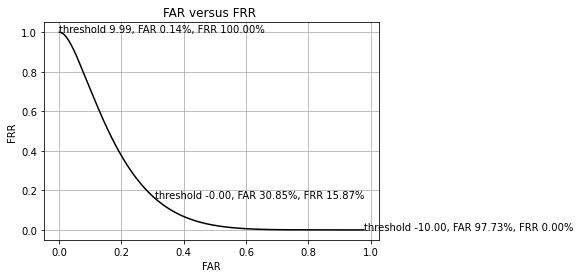

In [266]:
fig = plt.figure()
axis = fig.add_subplot(111)
axis.plot(far_array, frr_array, color = 'k')
axis.set_title('FAR versus FRR ')
axis.set_xlabel('FAR')
axis.set_ylabel('FRR')
axis.grid(visible=True)
plot_indices = [0, thresholds.size//2, thresholds.size-1]

for plot_idx in plot_indices:
    axis.text(far_array[plot_idx], frr_array[plot_idx], 
              'threshold {:.2f}, FAR {:.2f}%, FRR {:.2f}%'.format(thresholds[plot_idx], 
                                                                far_array[plot_idx] * 100, 
                                                                frr_array[plot_idx] * 100))

We can see that, if one increases, the other decreases.

This FRR-FAR curve is useful to show the trade-off when adjusting the threshold. 

A slightly different way to show the FRR-FAR curve is the wrap the x and y axes so that the curve can be "straightened".

Here, we use the method in [1] (eq.(1)) to wrap the x and y axes.

In [267]:
from scipy import special as scipy_special 
def probit(x):
    """ probit function to scale the axis
    based on __probit__(p) see [3]
    https://
    projets-lium.univ-lemans.fr/sidekit/_modules/sidekit/bosaris/detplot.html
    """
    return np.sqrt(2) * scipy_special.erfinv(2.0 * x - 1)

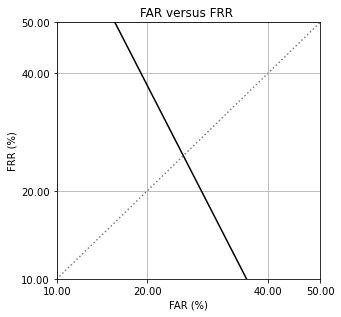

In [268]:
far_ar_wrapped = probit(far_array)
frr_ar_wrapped = probit(frr_array)

# for plotting the x-ticks and yticks
xticks = np.array([0.1, 0.2, 0.4, 0.5])
yticks = xticks

xtick_labels = ['{:.2f}'.format(x * 100) for x in xticks]
ytick_labels = ['{:.2f}'.format(x * 100) for x in yticks]

xticks = probit(xticks)
yticks = probit(yticks)


fig = plt.figure(figsize=(9.44/2, 9.44/2))
axis = fig.add_subplot(111)
axis.plot(far_ar_wrapped, frr_ar_wrapped, color = 'k')
axis.set_title('FAR versus FRR ')
axis.set_xlabel('FAR (%)')
axis.set_ylabel('FRR (%)')
axis.grid(visible=True)
axis.set_xticks(xticks)
axis.set_yticks(yticks)
axis.set_xticklabels(xtick_labels)
axis.set_yticklabels(ytick_labels)
axis.set_xlim(probit(0.1), probit(0.5))
axis.set_ylim(probit(0.1), probit(0.5))

axis.plot([probit(0.01), probit(0.5)], [probit(0.01), probit(0.5)], color='grey', linestyle=':')

The above figure is the Detection error trade-off (DET) curve [2].

We can see that the line is almost straight (see reason in [2]). 

This is good when we compare DET curves from different systems.


## EER

The threshold corresponding to any point on the DET curve is an operation point [1].

When we move the threshold (or the operation point), FAR and FRR change in opposite directions (in most cases).

Ideally, if there is an operation point where FAR = FRR, it is the operating point for the **equal equal rate**, and the value of FAR (and FRR) is equal to EER.

In the implementation, we only have a finite number of operation points on the DET curve, there is no guarantee that we can find one where FAR is exactly the same as FRR. 

The solution is to search for the operation point where abs(FAR-FRR) is minimum. Then, we compute EER = (FAR + FRR)/2. 

This is the idea behind the code in Section 1.


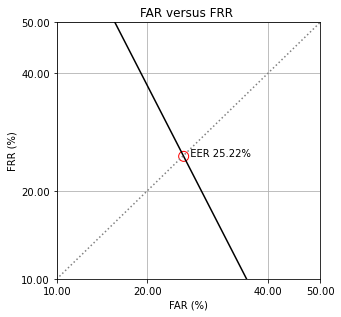

In [269]:

# find the minimum operation point
op_idx = np.argmin(np.abs(far_array - frr_array))
op_far_value = far_array[op_idx]
op_frr_value = frr_array[op_idx]
eer = (far_array[op_idx] + frr_array[op_idx]) / 2.0


fig = plt.figure(figsize=(9.44/2, 9.44/2))
axis = fig.add_subplot(111)
axis.plot(far_ar_wrapped, frr_ar_wrapped, color = 'k')
axis.set_title('FAR versus FRR ')
axis.set_xlabel('FAR (%)')
axis.set_ylabel('FRR (%)')
axis.grid(visible=True)
axis.set_xticks(xticks)
axis.set_yticks(yticks)
axis.set_xticklabels(xtick_labels)
axis.set_yticklabels(ytick_labels)
axis.set_xlim(probit(0.1), probit(0.5))
axis.set_ylim(probit(0.1), probit(0.5))

axis.scatter(probit(op_far_value), probit(op_frr_value), s=100.0, marker='o', facecolor='none', edgecolor='r')
axis.text(probit(op_far_value), probit(op_frr_value), '  EER {:.2f}%'.format(eer*100))

axis.plot([probit(0.01), probit(0.5)], [probit(0.01), probit(0.5)], color='grey', linestyle=':')

Back to the score distributions, we can plot it using the corresponding threshold

Text(1.6633663366336657, 0, 'FAR = 25.30%')

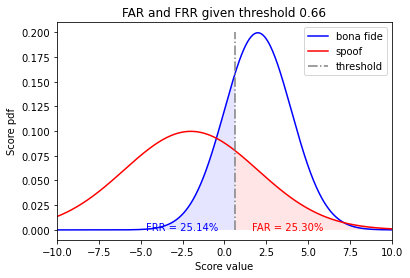

In [270]:
threshold = thresholds[op_idx]

binsize = np.mean(np.diff(x))

spoof_region = x<threshold
bona_region = x>=threshold
area_under_r_curve = np.sum(score_spoof_pdf) * binsize
area_under_b_curve = np.sum(score_bona_pdf) * binsize
fr = np.sum(score_bona_pdf[spoof_region]) * binsize
fa = np.sum(score_spoof_pdf[bona_region]) * binsize
frr = fr / area_under_b_curve
far = fa / area_under_r_curve

fig = plt.figure()
axis = fig.add_subplot(111)
axis.plot(x, score_bona_pdf, label = 'bona fide', color = 'b')
axis.plot(x, score_spoof_pdf, label = 'spoof', color = 'r')
axis.set_title('FAR and FRR given threshold {:.2f}'.format(threshold))
axis.set_xlabel('Score value')
axis.set_ylabel('Score pdf')
axis.set_xlim(-10, 10)
axis.plot([threshold, threshold], [0, 0.2], label = 'threshold', color = 'grey', linestyle='-.')
axis.legend()
axis.fill_between(x[spoof_region], np.zeros_like(x[spoof_region]), score_bona_pdf[spoof_region], facecolor='b', alpha=0.1)
axis.fill_between(x[bona_region], np.zeros_like(x[bona_region]), score_spoof_pdf[bona_region], facecolor='r', alpha=0.1)
axis.text(np.percentile(x[spoof_region], 99), 0, "FRR = {:.2f}%".format(frr * 100), color='b', ha='right')
axis.text(np.percentile(x[bona_region], 1), 0, "FAR = {:.2f}%".format(far * 100), color='r', ha='left')

Note that FAR is not perfectly equal to FRR because our threshold is moved by a stepsize of 0.01 in `thresholds = np.arange(-10, 10, 0.01)`.

You may try `thresholds = np.arange(-10, 10, 0.001)` (or stepsize = 1.0) to see what will happen. 


## Recap code in Section 1

Remember that how ideally we should compute

$\begin{align}
P_{\text{FAR}}(\tau_{\text{cm}}) &= \int_{\tau_{\text{cm}}}^{+\infty} P_{\text{spoof}}(s) ds \\
P_{\text{FRR}}(\tau_{\text{cm}}) &= \int_{-\infty}^{\tau_{\text{cm}}} P_{\text{bona}}(s) ds \\
\end{align}$


All the previous subsections in Section 2 assume that we know $p_{\text{spoof}}(s)$ or $p_{\text{bona}}(s)$. 

In real applications, we only have a limited number of scores for bona fide and spoofed trials, we can only estimate $p_{\text{spoof}}(s)$ or $p_{\text{bona}}(s)$ and approximate $P_{\text{FAR}}(\tau_{\text{cm}})$ and $P_{\text{FRR}}(\tau_{\text{cm}})$.


Given sets of scores for spoofed trials $\mathcal{S}_{\text{spoof}}$ and bona fide trials $\mathcal{S}_{\text{bona}}$,  the empirical FAR and FRR are given by (see Eq.(5) of [4]) 

$\begin{align}
\tilde{P}_{\text{FAR}}(\tau_{\text{cm}}) &\approx \frac{1}{|\mathcal{S}_{\text{spoof}}|} \sum_{s_i\in\mathcal{S}_{\text{spoof}}}\mathrm{1}({s_i > \tau_{\text{cm}}}) \\
\tilde{P}_{\text{FRR}}(\tau_{\text{cm}}) &\approx \frac{1}{|\mathcal{S}_{\text{bona}}|} \sum_{s_i\in\mathcal{S}_{\text{bona}}}\mathrm{1}({s_i < \tau_{\text{cm}}}) \\
\end{align}$

where $|\mathcal{S}_{\text{spoof}}|$ and $|\mathcal{S}_{\text{bona}}|$ are the number of spoofed and bona fide trials, respectively, and $\mathrm{1}$ is an indicator function.


Thus, we just need to count the number of trials below or above the threshold.


This is the idea of the functions in Section 1:

* `compute_det_curve` computes the FAR and FRR values for all possible operation points using the counting-based method

* `compute_eer` finds the operation point for EER and returns the value.


The function `compute_det_curve` uses some tricks to sort and count the values for FAR and FRR, but let's skip the details there.


## Properties of EER

**First**

EER is based on sorting and counting. Hence, linear, affine, or monotonic transformation on the scores will not change EER.

Let's use the actual bona fide and spoofed scores as an example.

In [271]:
# Let's use the actual scores used in Section 1
# load score
score_pd = pd.read_csv('ASVspoof2019.LA.cm.eval.score.txt', sep = ' ', names = ['trial', 'score'], index_col = 'trial', skipinitialspace=True)
# load protocol
protocol_pd = pd.read_csv('ASVspoof2019.LA.cm.eval.trl.txt', sep = ' ', names = ['speaker', 'trial', '-', 'attack', 'label'], index_col = 'trial')
# joint together
merged_pd = score_pd.join(protocol_pd)
# get ehe scores
bonafide_scores_orig = merged_pd.query('label == "bonafide"')['score'].to_numpy()
spoof_scores_orig = merged_pd.query('label == "spoof"')['score'].to_numpy()

def plot_score_dist(bona_scores, spoof_scores):
    eer, threshold = compute_eer(bona_scores, spoof_scores)
    fig = plt.figure()
    axis = fig.add_subplot(111)
    axis.hist(bona_scores, bins=300, density=True, histtype='step', label='bonafide', alpha=0.6)
    axis.hist(spoof_scores, bins=300, density=True, histtype='step', label='spoof', alpha=0.6)
    axis.plot([threshold, threshold], [0, 0.1], linestyle=':', color='grey', label='threshold')
    axis.legend()
    axis.text(threshold, 0.1, 'EER {:.2f}%'.format(eer * 100))
    axis.set_xlabel('Score value')
    axis.set_ylabel('Score histogram')
    return fig, axis

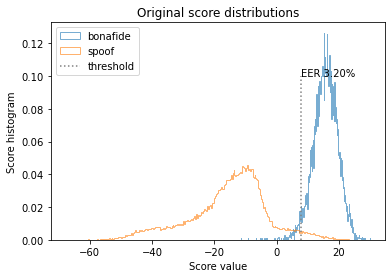

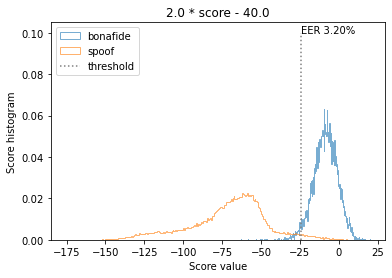

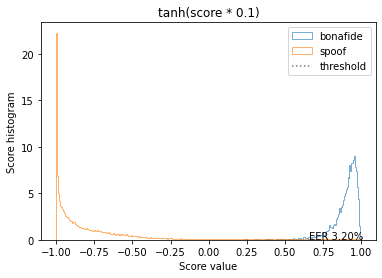

In [272]:
fig, axis = plot_score_dist(bonafide_scores_orig, spoof_scores_orig)
axis.set_title('Original score distributions');

# due to the finite number of bins in histogram, the density will look slightly different
fig, axis = plot_score_dist(bonafide_scores_orig * 2 - 40, spoof_scores_orig * 2 - 40)
axis.set_title('2.0 * score - 40.0');

# due to the finite number of bins in histogram, the density will look slightly different
fig, axis = plot_score_dist(np.tanh(bonafide_scores_orig * 0.1), np.tanh(spoof_scores_orig * 0.1))
axis.set_title('tanh(score * 0.1)');

**second**

EER is a non-linear function of scores. The EER over two sets of bona fide and spoofed scores is not necessarily equal to the mean of the EER on each individual set, even if the number of trials is the same in both sets.


What is worse, if there is a severe score shift, the EER over the pooled set will degrade. 


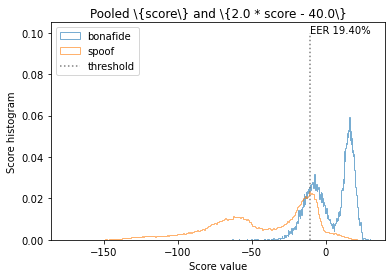

In [273]:
# due to the finite number of bins in histogram, the density will look slightly different

fig, axis = plot_score_dist(np.concatenate([bonafide_scores_orig, bonafide_scores_orig * 2 - 40], axis=0), 
                            np.concatenate([spoof_scores_orig, spoof_scores_orig * 2 - 40], axis=0))
axis.set_title('Pooled \{score\} and \{2.0 * score - 40.0\}');

This is a very vital issue when we compute an EER over pooled test sets.

The above issue is related to score calibration [1].

# Misc



## A wrapper to plot DET 

Here is one wrapper to plot the DET curve from bona fide and spoofed scores.

In [274]:
import matplotlib.pyplot as plt
from scipy import special as scipy_special 

def probit(x):
    """ probit function to scale the axis
    based on __probit__(p) see [3]
    https://
    projets-lium.univ-lemans.fr/sidekit/_modules/sidekit/bosaris/detplot.html
    """
    return np.sqrt(2) * scipy_special.erfinv(2.0 * x - 1)



def plot_det_curve(bona_scores, spoofed_scores, show_range=np.array([0.1, 0.2, 0.4, 0.5])):
    """ fig, axis = plot_det_curve(bona_scores, spoofed_scores)
    input
    -----
      bona_scores:    np.array, scores of bona fide trials
      spoofed_scores: np.array, scores of spoofed trials
      
    output
    ------
      fig:   matplotlib figure handler
      axis:  matplotlib axis handler
    """
    frr_array, far_array, _ = compute_det_curve(bona_scores, spoofed_scores)
    eer, _ = compute_eer(bona_scores, spoofed_scores)
    far_ar_wrapped = probit(far_array)
    frr_ar_wrapped = probit(frr_array)

    # for plotting the x-ticks and yticks
    xticks = show_range
    yticks = xticks

    xtick_labels = ['{:.2f}'.format(x * 100) for x in xticks]
    ytick_labels = ['{:.2f}'.format(x * 100) for x in yticks]

    xticks = probit(xticks)
    yticks = probit(yticks)

    fig = plt.figure(figsize=(9.44/2, 9.44/2))
    axis = fig.add_subplot(111)
    axis.plot(far_ar_wrapped, frr_ar_wrapped, color = 'k')
    axis.set_title('FAR versus FRR ')
    axis.set_xlabel('FAR (%)')
    axis.set_ylabel('FRR (%)')
    axis.grid(visible=True)
    axis.set_xticks(xticks)
    axis.set_yticks(yticks)
    axis.set_xticklabels(xtick_labels)
    axis.set_yticklabels(ytick_labels)
    axis.set_xlim(probit(show_range[0]), probit(show_range[-1]))
    axis.set_ylim(probit(show_range[0]), probit(show_range[-1]))
    axis.text(probit(eer), probit(eer), 'EER {:.2f}%'.format(eer * 100))
    axis.plot([probit(0.01), probit(0.5)], [probit(0.01), probit(0.5)], color='grey', linestyle=':')
    return fig, axis

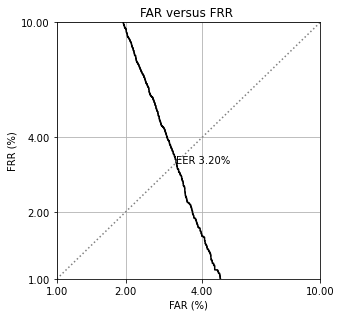

In [275]:
# Let's use the actual scores used in Section 1

# load score
score_pd = pd.read_csv('ASVspoof2019.LA.cm.eval.score.txt', sep = ' ', names = ['trial', 'score'], index_col = 'trial', skipinitialspace=True)
# load protocol
protocol_pd = pd.read_csv('ASVspoof2019.LA.cm.eval.trl.txt', sep = ' ', names = ['speaker', 'trial', '-', 'attack', 'label'], index_col = 'trial')
# joint together
merged_pd = score_pd.join(protocol_pd)
    
# get ehe scores
bonafide_scores = merged_pd.query('label == "bonafide"')['score'].to_numpy()
spoof_scores = merged_pd.query('label == "spoof"')['score'].to_numpy()
    

fig, axis = plot_det_curve(bonafide_scores, spoof_scores, show_range=np.array([0.01, 0.02, 0.04, 0.1]))

# Reference

```sh
[1] David A Van Leeuwen, and Niko Brümmer. An Introduction to Application-Independent Evaluation of Speaker Recognition Systems. In Speaker Classification I, 330–353. Springer. 2007.


[2] Alvin Martin, George Doddington, Terri Kamm, Mark Ordowski, and Mark Przybocki. The DET Curve in Assessment of Detection Task Performance. In Proc. Eurospeech, 1895–1898. 1997.

[3] Niko Brümmer, and Edward De Villiers. The Bosaris Toolkit: Theory, Algorithms and Code for Surviving the New Dcf. ArXiv Preprint ArXiv:1304.2865. 2013.

[4] Tomi Kinnunen, Hector Delgado, Nicholas Evans, Kong Aik Lee, Ville Vestman, Andreas Nautsch, Massimiliano Todisco, Xin Wang, Md Sahidullah, Junichi Yamagishi, and Douglas A Reynolds. Tandem Assessment of Spoofing Countermeasures and Automatic Speaker Verification: Fundamentals. IEEE/ACM Transactions on Audio, Speech, and Language Processing 28. IEEE: 2195–2210. doi:10.1109/TASLP.2020.3009494. 2020.

```

---
That's all